## Week 6 Homework

---



### Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification 

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize 
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to smaple from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*


<>:77: SyntaxWarning: invalid escape sequence '\m'
<>:80: SyntaxWarning: invalid escape sequence '\s'
<>:83: SyntaxWarning: invalid escape sequence '\m'
<>:77: SyntaxWarning: invalid escape sequence '\m'
<>:80: SyntaxWarning: invalid escape sequence '\s'
<>:83: SyntaxWarning: invalid escape sequence '\m'
/var/folders/bv/vygjq17x6b9cd3zlg75njds80000gn/T/ipykernel_11549/964785951.py:77: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_title("Posterior Distribution of $\mu$")
/var/folders/bv/vygjq17x6b9cd3zlg75njds80000gn/T/ipykernel_11549/964785951.py:80: SyntaxWarning: invalid escape sequence '\s'
  axes[1].set_title("Posterior Distribution of $\sigma^2$")
/var/folders/bv/vygjq17x6b9cd3zlg75njds80000gn/T/ipykernel_11549/964785951.py:83: SyntaxWarning: invalid escape sequence '\m'
  axes[2].set_title("Posterior Distribution of $\mathcal{V}$")


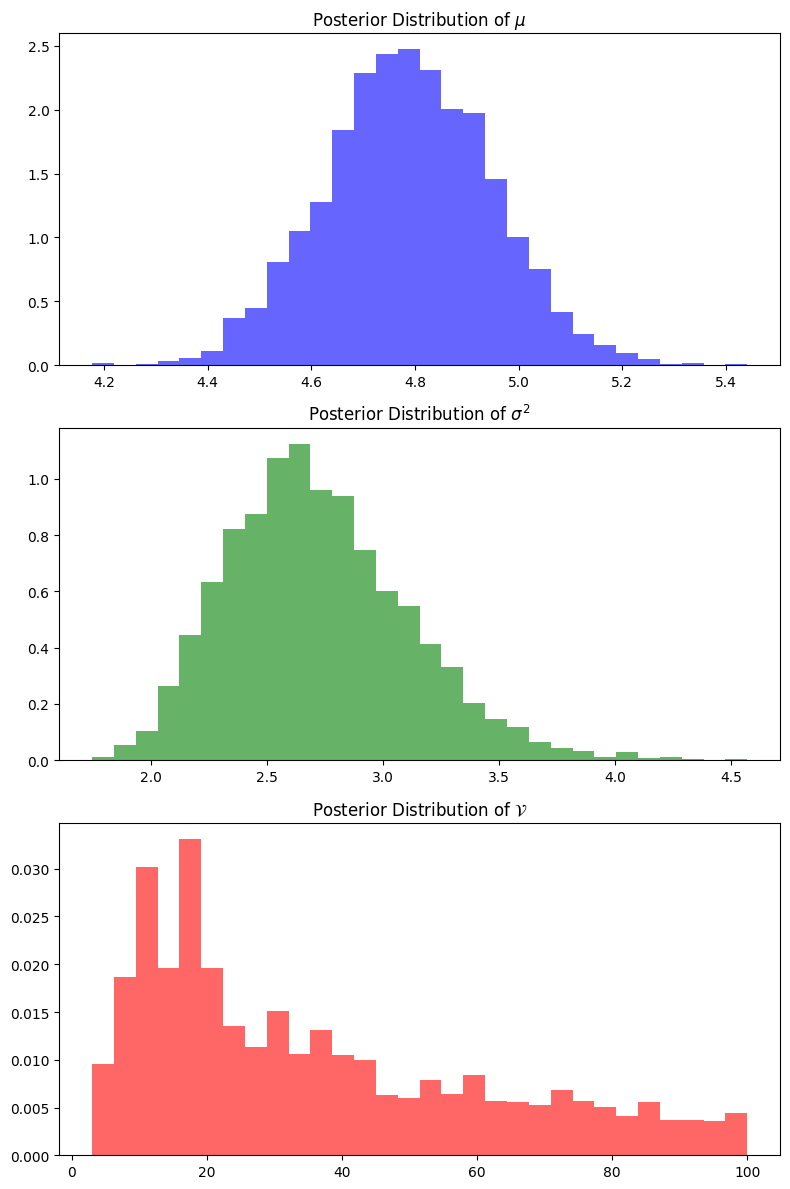

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# True parameters for generating synthetic data
mu_true = 5
sigma2_true = 2
nu_true = 10
n = 100

# Generate synthetic data from a Student's t distribution
x = stats.t.rvs(df=nu_true, loc=mu_true, scale=np.sqrt(sigma2_true), size=n)

# Priors
mu0 = 0  # Prior mean for mu
tau0 = 1  # Precision for mu (1/variance)
sigma0 = 1  # Scale parameter for half-normal prior on sigma^2

# Metropolis-within-Gibbs parameters
num_samples = 5000
burn_in = 1000

# Initialize chains
mu_chain = np.zeros(num_samples)
sigma2_chain = np.zeros(num_samples)
nu_chain = np.zeros(num_samples)

# Initialize parameters
mu_chain[0] = np.mean(x)
sigma2_chain[0] = np.var(x, ddof=1)
nu_chain[0] = np.random.randint(1, 101)

# compute log-posterior for nu
def log_posterior_nu(nu, x, mu, sigma2):
    log_likelihood = stats.t.logpdf(x, df=nu, loc=mu, scale=np.sqrt(sigma2)).sum()
    log_prior = -np.log(100)  
    return log_likelihood + log_prior

# Gibbs Sampler
for t in range(1, num_samples):
    # Sample mu | sigma2, nu
    sigma_mu = 1 / (tau0 + n / sigma2_chain[t-1])
    mu_n = sigma_mu * (tau0 * mu0 + np.sum(x) / sigma2_chain[t-1])
    mu_chain[t] = np.random.normal(mu_n, np.sqrt(sigma_mu))
    
    # Sample sigma2 | mu, nu using a half-normal prior
    residuals = (x - mu_chain[t])**2
    shape = n / 2 + 1  # Half-normal prior behaves like an inverse-gamma
    scale = np.sum(residuals) / 2 + sigma0**2
    sigma2_chain[t] = 1 / np.random.gamma(shape, 1/scale)
    
    # Sample nu using Metropolis-Hastings
    nu_current = nu_chain[t-1]
    nu_proposal = np.random.randint(1, 101)  # Randomly propose a new nu in [1,100]
    
    log_accept_ratio = log_posterior_nu(nu_proposal, x, mu_chain[t], sigma2_chain[t]) - \
                       log_posterior_nu(nu_current, x, mu_chain[t], sigma2_chain[t])
    
    if np.log(np.random.uniform()) < log_accept_ratio:
        nu_chain[t] = nu_proposal
    else:
        nu_chain[t] = nu_current

# Remove burn-in samples
mu_chain = mu_chain[burn_in:]
sigma2_chain = sigma2_chain[burn_in:]
nu_chain = nu_chain[burn_in:]

# Plot the posterior distributions
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

axes[0].hist(mu_chain, bins=30, density=True, alpha=0.6, color="blue")
axes[0].set_title("Posterior Distribution of $\mu$")

axes[1].hist(sigma2_chain, bins=30, density=True, alpha=0.6, color="green")
axes[1].set_title("Posterior Distribution of $\sigma^2$")

axes[2].hist(nu_chain, bins=30, density=True, alpha=0.6, color="red", align="mid")
axes[2].set_title("Posterior Distribution of $\mathcal{V}$")

plt.tight_layout()
plt.show()



### Q2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*



Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)



Sample Size: 10
      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  45.806  27.776     2.0     90.0      1.861    1.317     185.0     103.0   

    r_hat  
nu    NaN  

Sample Size: 50
      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  51.455  28.186     7.0     95.0       2.19    1.552     162.0     199.0   

    r_hat  
nu    NaN  

Sample Size: 200
      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  31.606  25.503     4.0     86.0      6.003    4.315      17.0      72.0   

    r_hat  
nu    NaN  


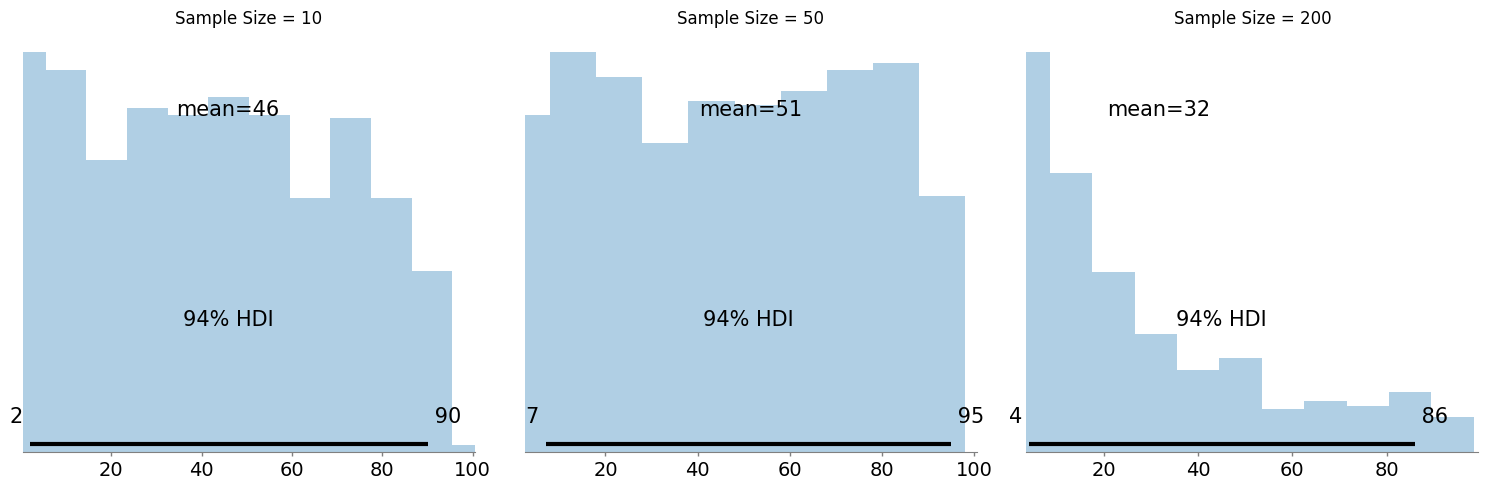

In [3]:
import numpy as np
import pymc as pm
import arviz as az
import scipy.stats as stats
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Function to run PyMC inference for different sample sizes
def run_pymc_inference(n, true_nu=10):
    """
    Runs Bayesian inference in PyMC for the specified sample size n.

    Arguments:
    n -- Sample size
    true_nu -- True degrees of freedom for data generation

    Returns:
    Trace of posterior samples
    """
    # Generate synthetic data from Student's t-distribution
    mu_true = 5
    sigma_true = np.sqrt(2)
    x = stats.t.rvs(df=true_nu, loc=mu_true, scale=sigma_true, size=n)

    # Define the Bayesian model in PyMC
    with pm.Model() as model:
        # Priors
        mu = pm.Normal("mu", mu=0, sigma=1)  # Prior for mu
        sigma = pm.HalfNormal("sigma", sigma=1)  # Half-normal prior for sigma
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)  # Discrete uniform prior for nu

        # Likelihood
        y_obs = pm.StudentT("y_obs", nu=nu, mu=mu, sigma=sigma, observed=x)

        # Run MCMC sampling with optimizations
        trace = pm.sample(1000, tune=500, return_inferencedata=True, chains=1, cores=1, progressbar=True)

    return trace

# Run inference for different sample sizes
sample_sizes = [10, 50, 200]
traces = {n: run_pymc_inference(n) for n in sample_sizes}

# Summarize results
summary_stats = {n: az.summary(traces[n], var_names=["nu"]) for n in sample_sizes}

# Display results
for n in sample_sizes:
    print(f"\nSample Size: {n}")
    print(summary_stats[n])

# Plot posterior distributions for nu
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, n in enumerate(sample_sizes):
    az.plot_posterior(traces[n], var_names=["nu"], ax=axes[i])
    axes[i].set_title(f"Sample Size = {n}")

plt.tight_layout()
plt.show()


### Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$


The given integral integrates out the uncertainty in $\tau_i$ and gives us a new distribution of $y_i$ that doesn't depend on the latent precision variable.
If we combine the powers of $\tau_i$ in the integral, we can recognize it as the t-distribution using the Gamma-Normal conjugacy. 
$$\int \frac{\nu}{2}^{\frac{\nu}{2}} \frac{1}{\Gamma(\nu/2)} \sqrt{\frac{1}{2\pi}} \tau_i^{\frac{\nu}{2} - \frac{1}{2} - 1} e^{-\left(\frac{\nu}{2} + \frac{1}{2} y_i^2\right) \tau_i} d\tau_i$$
Using the Gamma function identity:
$$\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)} \frac{1}{\sqrt{\pi \nu}} \left(1 + \frac{y_i^2}{\nu} \right)^{-\frac{\nu+1}{2}}$$
which is the Student’s t-distribution:
$$y_i \sim t_{\nu}(0, 1)$$

This behavior is analagous to the posterior predictive distribution because it increases robustness in the model by accounting for variance uncertainty for our predictions. (Since the posterior predictive distribution also integrates over uncertainty in parameters ) 